In [74]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import copy

torch.manual_seed(0)


Each project follows the same overall structure:

- Download the data and preprocess it as required for the given task (if needed).
- Write a Dataset class for creating the train and test datasets (and corresponding dataloaders).
- Define the neural network model.
- Define the hyperparameters to create an instance of the model (e.g., hidden space size, number of convolution kernels...) as well as the parameters required to train neural network (e.g., learning rate).
- Write the training loop for training the model.
- Evaluate the model on the test data. In this part, it is expected to choose an appropriate evaluation metric based on your task. For instance, for classification task, accuracy should be computed (but you can also search for 'precision' and 'recall').
Save the trained model parameters, and the obtained results if needed.
- Ideally, visualize the results, e.g., display an image/audio/text, along with the true and estimated label. As bonus you can also compute the t-sne embeddings over layers, plot a confusion matrix between classes to see where errors come from, etc.

In [ ]:
# Each numpy file has 2062

X = np.load('./Sign-language-digits-dataset/X.npy')
y = np.load('./Sign-language-digits-dataset/Y.npy')

In [ ]:
print(X[0])

[[0.46666667 0.4745098  0.47843137 ... 0.5176471  0.5137255  0.5019608 ]
 [0.49803922 0.4862745  0.4862745  ... 0.5254902  0.5176471  0.50980395]
 [0.54509807 0.49411765 0.49019608 ... 0.5294118  0.5254902  0.5137255 ]
 ...
 [0.5019608  0.5137255  0.5176471  ... 0.5529412  0.54509807 0.53333336]
 [0.49803922 0.5058824  0.5137255  ... 0.54509807 0.53333336 0.52156866]
 [0.49019608 0.49803922 0.5019608  ... 0.5294118  0.52156866 0.50980395]]


In [29]:
y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
print(X[0].shape)

(64, 64)


In [ ]:
# takes a set of numpy and returns an image

def myplot(x):
    plt.figure()
    plt.imshow(x, cmap='gray')
    plt.show()
    return

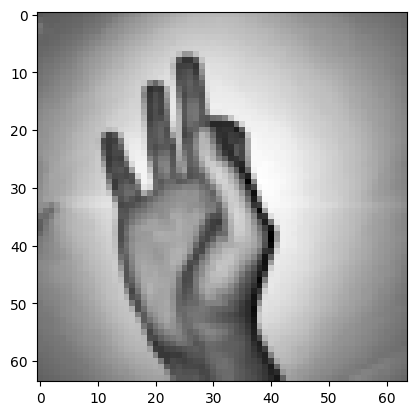

In [ ]:
myplot(X[0])

## Split into Train, Validation and Test

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [ ]:
print('Len train: ', len(X_train))
print('Len valid: ', len(X_valid))
print('Len test: ', len(X_test))

Len train:  1649
Len valid:  207
Len test:  206


In [71]:
class DigitDataset(Dataset):
  def __init__(self, images, labels):
        self.labels = labels
        self.images = images

  def __len__(self):
        return len(self.images)

  def __getitem__(self, index):
        x = self.images[index]
        Y = self.labels[index].ToTensor()
        X = torch.from_numpy(x).unsqueeze(dim=0)

        return X, Y

In [72]:
BATCH_SIZE = 8

train_set = DigitDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

valid_set = DigitDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_set)

test_set = DigitDataset(X_test, y_test)
test_loader = DataLoader(test_set)

In [73]:
next(iter(train_set))

(tensor([[[0.5608, 0.5647, 0.5647,  ..., 0.5412, 0.5490, 0.5451],
          [0.5608, 0.5725, 0.5765,  ..., 0.5608, 0.5608, 0.5529],
          [0.5647, 0.5765, 0.5804,  ..., 0.5725, 0.5686, 0.5569],
          ...,
          [0.5137, 0.5176, 0.5176,  ..., 0.4941, 0.4941, 0.4863],
          [0.5098, 0.5098, 0.5098,  ..., 0.4941, 0.4902, 0.4784],
          [0.5020, 0.5020, 0.5059,  ..., 0.4863, 0.4824, 0.4706]]]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

In [37]:
labels_batch_example.shape

torch.Size([8, 10])

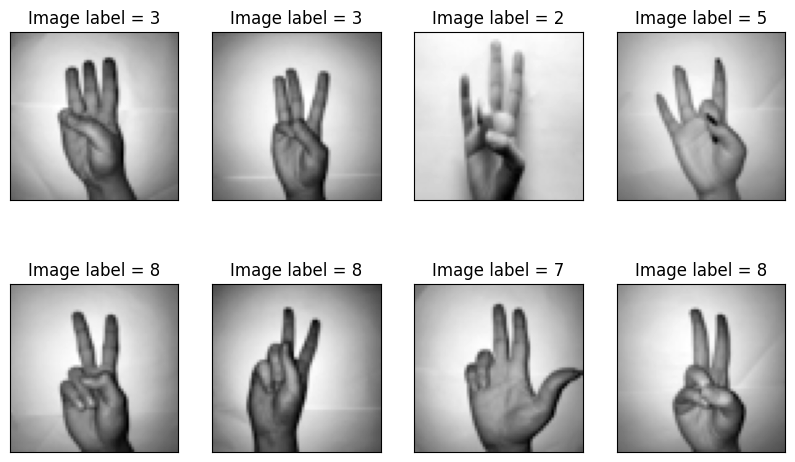

In [81]:
image_batch_example, labels_batch_example = next(iter(train_loader))

plt.figure(figsize = (10,6))
for ib in range(BATCH_SIZE):
    plt.subplot(BATCH_SIZE // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze().detach(), cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(torch.argmax(labels_batch_example[ib]).item()))
plt.show()

In [ ]:
# Ordering of digits according to OHV
# 9, 0, 7, 6, 1, 8, 4, 3, 2, 5

In [41]:
image_batch_example, labels_batch_example = next(iter(train_loader))

print(image_batch_example.shape)

torch.Size([8, 1, 64, 64])


# **Classifier**

In [47]:
# Checking input size for linear layer

cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out1 = cnn_layer1(image_batch_example)

cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size =2))
out2 = cnn_layer2(out1)

out_vec = out2.reshape(out2.shape[0], -1)

print(out_vec.shape)

torch.Size([8, 8192])


In [42]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

In [43]:
class CNNClassif(nn.Module):
    def __init__(self, input_size_linear, num_channels1=16, num_channels2=32, num_classes=10):
        super().__init__()

        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.lin_layer = nn.Linear(input_size_linear, num_classes)

    def forward(self, x):

        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        return out

In [113]:
num_channels1 = 16
num_channels2 = 32
num_classes = 10
input_size_linear = 8192
model = CNNClassif(input_size_linear, num_channels1, num_channels2, num_classes)

print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

torch.manual_seed(0)
model.apply(init_weights)

Total number of parameters:  95178


CNNClassif(
  (cnn_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin_layer): Linear(in_features=8192, out_features=10, bias=True)
)

In [114]:
def training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    model_tr = copy.deepcopy(model)

    model_tr.train()

    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)

    train_losses = []

    for epoch in range(num_epochs):
        tr_loss = 0

        for batch_index, (images, labels) in enumerate(train_dataloader):

            y_predicted = model_tr(images)
            loss = loss_fn(y_predicted, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss += loss.item() * images.shape[0]

        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)

        if verbose:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, tr_loss))

    return model_tr, train_losses

Epoch [1/50], Loss: 2.3021
Epoch [2/50], Loss: 2.1775
Epoch [3/50], Loss: 1.4716
Epoch [4/50], Loss: 0.9102
Epoch [5/50], Loss: 0.8330
Epoch [6/50], Loss: 0.6189
Epoch [7/50], Loss: 0.5318
Epoch [8/50], Loss: 0.4648
Epoch [9/50], Loss: 0.4101
Epoch [10/50], Loss: 0.3662
Epoch [11/50], Loss: 0.3563
Epoch [12/50], Loss: 0.2786
Epoch [13/50], Loss: 0.2393
Epoch [14/50], Loss: 0.2087
Epoch [15/50], Loss: 0.1824
Epoch [16/50], Loss: 0.2203
Epoch [17/50], Loss: 0.1408
Epoch [18/50], Loss: 0.1156
Epoch [19/50], Loss: 0.1108
Epoch [20/50], Loss: 0.2039
Epoch [21/50], Loss: 0.0904
Epoch [22/50], Loss: 0.0669
Epoch [23/50], Loss: 0.0521
Epoch [24/50], Loss: 0.0484
Epoch [25/50], Loss: 0.0462
Epoch [26/50], Loss: 0.0387
Epoch [27/50], Loss: 0.0284
Epoch [28/50], Loss: 0.0251
Epoch [29/50], Loss: 0.0247
Epoch [30/50], Loss: 0.0179
Epoch [31/50], Loss: 0.0124
Epoch [32/50], Loss: 0.0097
Epoch [33/50], Loss: 0.0088
Epoch [34/50], Loss: 0.0075
Epoch [35/50], Loss: 0.0063
Epoch [36/50], Loss: 0.0059
E

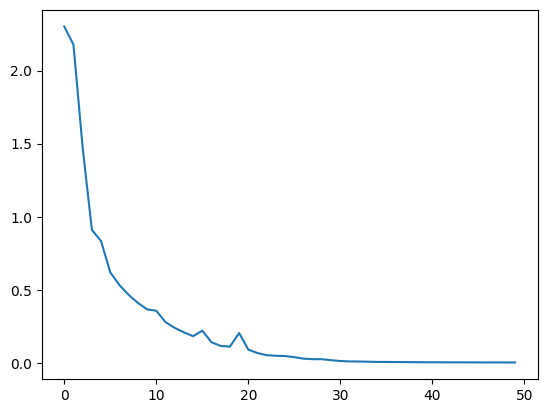

In [115]:
num_epochs = 50
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

model, train_losses = training_cnn_classifier(model, train_loader, num_epochs, loss_fn, learning_rate, verbose=True)

torch.save(model.state_dict(), 'model_cnn_classif.pt')
plt.plot(train_losses)
plt.show()

In [116]:
def eval_cnn_classifier(model, eval_loader):

    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in eval_loader:
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == torch.argmax(labels)).sum().item()

    accuracy = 100 * correct / total

    return accuracy

In [117]:
model = CNNClassif(input_size_linear, num_channels1, num_channels2, num_classes)
model.load_state_dict(torch.load('model_cnn_classif.pt'))
accuracy = eval_cnn_classifier(model, test_loader)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  91.74757281553399 %
